# Optimization with exclusion zones

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/bathymetry.ipynb) (requires google account)


In this example, the bathymetric optimization problem is solved for a maximum water depth permissible and with the addition of exlusion zones, which add boundary constraints to the optimization problem. The exclusion zone is characterized for having a larger water depth than allowed.

**Install TOPFARM if needed**

In [ ]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

**First we import basic Python elements and some TOPFARM classes**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm import TopFarmProblem
from topfarm.plotting import NoPlot, XYPlotComp
from topfarm.constraint_components.boundary import XYBoundaryConstraint, InclusionZone, ExclusionZone
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.examples.data.parque_ficticio_offshore import ParqueFicticioOffshore

from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from py_wake.examples.data.iea37._iea37 import IEA37_WindTurbines

**Setting up the site and exclusion zone**

To set up the exlusion zone, we use polygon tracing for the maximum water depth by utilizing the **boundary_type='multipolygon'** keyword.

In [ ]:
#setting up the site and the initial position of turbines
site = ParqueFicticioOffshore()
site.bounds = 'ignore'
x_init, y_init = site.initial_position[:, 0], site.initial_position[:, 1]
boundary = site.boundary

# Wind turbines and wind farm model definition
windTurbines = IEA37_WindTurbines()
wfm = IEA37SimpleBastankhahGaussian(site, windTurbines)

#parameters for the AEP calculation 
wsp = np.asarray([10, 15])
wdir = np.arange(0, 360, 45)
n_wt = x_init.size

#setting up the exclusion zone
maximum_water_depth = -52
values = site.ds.water_depth.values
x = site.ds.x.values
y = site.ds.y.values
levels = np.arange(int(values.min()), int(values.max()))
max_wd_index = int(np.argwhere(levels == maximum_water_depth))

cs = plt.contour(x, y, values.T, levels)

lines = []
if max_wd_index < len(cs.collections):
    for line in cs.collections[max_wd_index].get_paths():
        lines.append(line.vertices)
else:
    print("Maximum water depth index is out of range.")
plt.close()

# Convert lines to a numpy array safely
if lines:
    lines_array = np.vstack(lines) 
    xs = lines_array[:, 0]          
    ys = lines_array[:, 1]          
else:
    xs, ys = np.array([]), np.array([])  # Handle case with no lines

if xs.size == 0 or ys.size == 0:
    print("No valid contour lines found.")
else:
    print("exlusion zone found")

exlusion zone found


c:\Users\faepi\AppData\Local\anaconda3\envs\topfarm\Lib\site-packages\py_wake\deficit_models\gaussian.py:278: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')
C:\Users\faepi\AppData\Local\Temp\ipykernel_7200\3906457900.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max_wd_index = int(np.argwhere(levels == maximum_water_depth))
C:\Users\faepi\AppData\Local\Temp\ipykernel_7200\3906457900.py:27: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if max_wd_index < len(cs.collections):
C:\Users\faepi\AppData\Local\Temp\i

**Now we set up the objective function,** `CostModelComponent` **and** `TopFarmProblem`.

In [ ]:
def aep_func(x, y, **kwargs):
    simres = wfm(x, y, wd=wdir, ws=wsp)
    aep = simres.aep().values.sum()
    water_depth = np.diag(wfm.site.ds.interp(x=x, y=y)['water_depth'])
    return [aep, water_depth]
    
#parameters for the optimization problem
tol = 1e-8
ec = 1e-2
maxiter = 30
min_spacing = 260

#Cost model component and Topfarm problem

cost_comp = CostModelComponent(input_keys=[('x', x_init),('y', y_init)],
                                          n_wt=n_wt,
                                          cost_function=aep_func,
                                          objective=True,
                                          maximize=True,
                                          output_keys=[('AEP', 0), ('water_depth', np.zeros(n_wt))]
                                          )

problem = TopFarmProblem(design_vars={'x': x_init, 'y': y_init},
                         constraints=[XYBoundaryConstraint([InclusionZone(boundary), ExclusionZone(np.asarray((xs,ys)).T)], boundary_type='multi_polygon'),
                                      SpacingConstraint(min_spacing)],
                         cost_comp=cost_comp,
                         n_wt = n_wt,
                         driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=maxiter, tol=tol),
                         plot_comp=XYPlotComp(),
                         expected_cost=ec)

100%|██████████| 2/2 [00:00<?, ?it/s]

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


**Now we run the optimization**

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


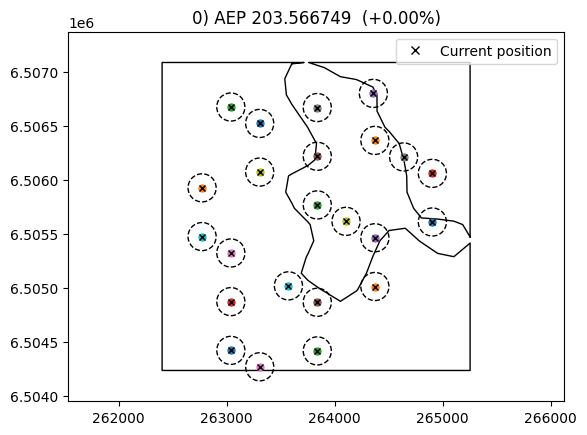

Iteration limit reached    (Exit mode 9)
            Current function value: -23918.196638074332
            Iterations: 30
            Function evaluations: 31
            Gradient evaluations: 30
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization took: 39s


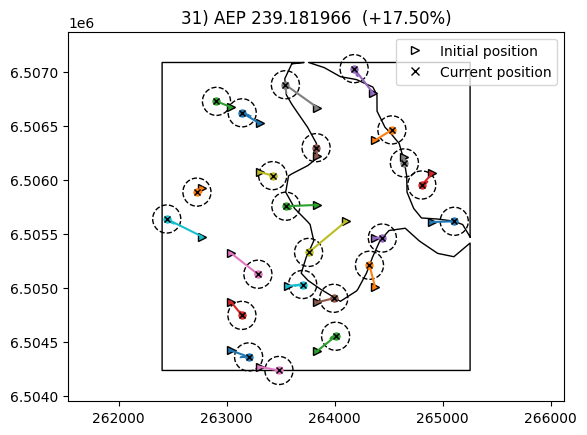

In [ ]:
tic = time.time()

cost, state, recorder = problem.optimize()
toc = time.time()
print('Optimization took: {:.0f}s'.format(toc-tic))


Here we can see the exclusion zone and how the optimized turbine positions stay away from this area. The turbines are positioned at the boundaries and the improvement in AEP is of 4.88% compared to the baseline.

We can use the recorder to plot the evolution of the water depth with each iteration.

Text(0, 0.5, 'Max depth [m]')

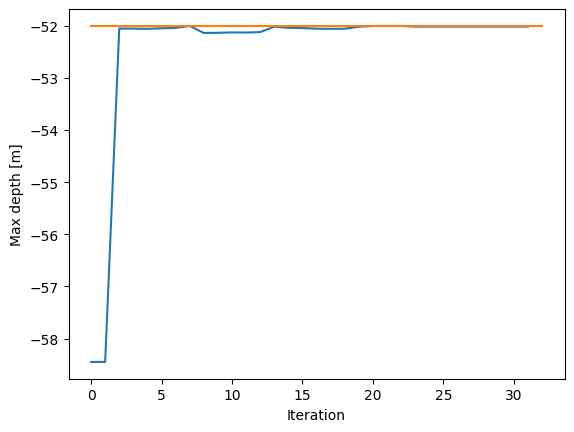

In [ ]:
plt.plot(recorder['water_depth'].min((1)))
plt.plot([0,recorder['water_depth'].shape[0]],[maximum_water_depth, maximum_water_depth])
plt.xlabel('Iteration')
plt.ylabel('Max depth [m]')

We can also visualize the initial vs optimized layout as countour plots that show the water depth. Note how it is clear how the optimized positions do not cross the boundary set for the water depth.

Text(0.5, 1.0, 'Max Water Depth Boundary: -52 m')

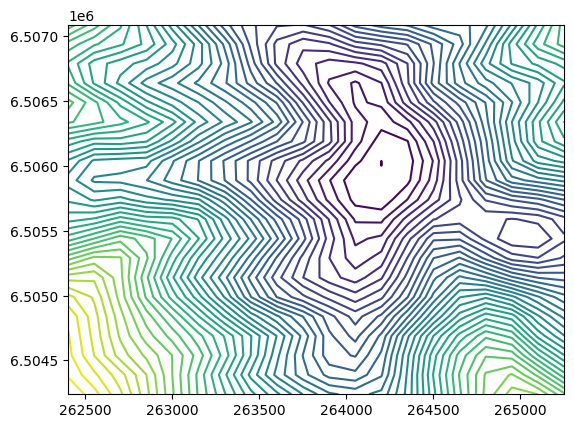

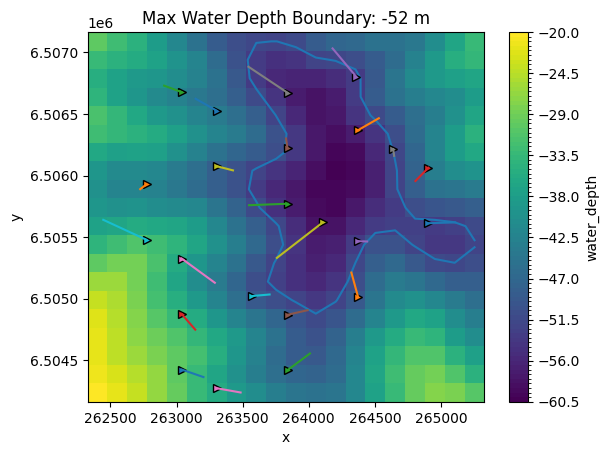

In [ ]:
cs = plt.contour(x, y , values.T, levels)
fig2, ax2 = plt.subplots(1)
site.ds.water_depth.plot(ax=ax2, levels=100)
ax2.plot(xs, ys)
problem.model.plot_comp.plot_initial2current(x_init, y_init, state['x'], state['y'])
ax2.set_title(f'Max Water Depth Boundary: {maximum_water_depth} m')